<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/07_experiment_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FoodVision Mini Experiment Tracking

Different ways to track ML Experiments
1. Python dict
2. TensorBoard
3. Weights & Biases
4. MLFlow

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
  from torchmetrics import Accuracy
except:
  print('[INFO] Installing torchinfo and torchmetrics')
  !pip install -q torchinfo
  !pip install torchmetrics

[INFO] Installing torchinfo and torchmetrics
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 42.3 MB/s eta 0:00:00


In [2]:
# import neccessry function from modular_pytorch

try:
  from modualr_pytorch import data_setup, engine
except:
  print('[INFO] Downloading scripts from github...')
  !git clone https://github.com/aashu-0/learn-pytorch
  !mv learn-pytorch/modualr_pytorch .
  !rm -rf learn-pytorch
  from modualr_pytorch import data_setup, engine

[INFO] Downloading scripts from github...
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 77 (delta 28), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 42.68 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [3]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# let's this time create a function to set random seeds
def set_seeds(seed: int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

### 1. Get Data

In [5]:
# get data
from modualr_pytorch import get_data
# directories
train_dir = get_data.image_path/'train'
test_dir = get_data.image_path/'test'

data/pizza_steak_sushi does not exists...creating one
Downloading....the github zip file
Unzipping the zip file


### 2. Datasets and DataLoaders
- manually created transform using `torchvision.transforms`
- automatically using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`

In [6]:
# 1. manually

# normalization as per ImageNet dataset
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std= [0.229,0.224,0.225])

# manual transform pipeline
manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transform: {manual_transform}")

Manually created transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
# train and test dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform= manual_transform,
    batch_size= BATCH_SIZE,
    num_workers= NUM_WORKERS
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d09d08530d0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# 2. using automatic transform

# setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# get transforms from weights
automatic_transforms = weights.transforms()

print(f'Automatically created transform: {automatic_transforms}')

# dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform= automatic_transforms,
    batch_size= BATCH_SIZE,
    num_workers= NUM_WORKERS
)

train_dataloader, test_dataloader, class_names

Automatically created transform: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7d0aa3972f50>,
 ['pizza', 'steak', 'sushi'])

### Getting a pretrained model, frezzing the base model, and changing the classifier head as our own data

In [9]:
# download pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# setup model with pretrained weights
model = torchvision.models.efficientnet_b0(weights= weights).to(device)

# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


In [10]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

turning `model` int a feature extractor model
- freeze the base layers -> i.e now no update in their weights
  * we will use these to extract features from our input image
- we'll change the classifier head

In [11]:
# freeze all the layers
for parm in model.features.parameters():
  parm.requires_grad = False

# set seed
set_seeds()

# update the classifier head
model.classifier = torch.nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                       nn.Linear(in_features=1280,
                                                 out_features=len(class_names),
                                                 bias=True).to(device))

In [12]:
# get summary
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

the trainable row indicates layers which can be trained or not

### Train model and track results

In [13]:
from torchmetrics import Accuracy
# loss, optimizer and accuracy function
loss_fn = nn.CrossEntropyLoss()
acc_fn= Accuracy(task= 'multiclass', num_classes=len(class_names)).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

###We adjust our pre-existing `train()` function to track results using tensorboard
  - using `torch.utils.tensorboard.SummaryWriter()` class

In [14]:
# create a SummaryWriter() instance
try:
  from torch.utils.tensorboard import SummaryWriter
except:
  print('[INFO] Installing tensorboard...')
  !pip install tensorboard
  from torch.utils.tensorboard  import SummaryWriter

writer = SummaryWriter()

we will make some changes in our train function to track values like training and test loss and accuracy.
- `writer.add_scalers()` -> to track scalers like loss and accuracy
- `writer.close()` -> to tell the writer to stop tracking

In [15]:
# import train adn test step func from engine
from typing import List, Dict
import torchmetrics
from tqdm.auto import tqdm
from modualr_pytorch.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          accuracy_fn: torchmetrics.Accuracy,
          epochs: int,
          device: torch.device)-> dict[str, List]:

  # empty result dict
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}
  # loop
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer= optimizer,
                                       accuracy_fn=acc_fn,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn=acc_fn,
                                    device = device)
    # print out what's happening
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

    # update the dict
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    ##EXPERIMENT TRACKING##
    # add loss to SummaryWriter
    writer.add_scalars(main_tag='Loss',
                       tag_scalar_dict= {'train_loss': train_loss,
                                         'test_loss' : test_loss},
                       global_step=epoch)

    #add Accuracy to SummaryWriter
    writer.add_scalars(main_tag='Accuracy',
                       tag_scalar_dict= {'train_acc': train_acc,
                                         'test_acc' : test_acc},
                       global_step=epoch)

    # track pytorch model architecture
    writer.add_graph(model=model,
                     # pass an example input
                     input_to_model=torch.randn(32,3,224,224).to(device))


  # close the writer
  writer.close()

  #return the end results
  return results

In [16]:
# let's train
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                accuracy_fn=acc_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0924 | Train acc: 0.3984 | Test Loss: 0.9133 | Test acc: 0.5398
Epoch: 1 | Train Loss: 0.8975 | Train acc: 0.6562 | Test Loss: 0.7837 | Test acc: 0.8561
Epoch: 2 | Train Loss: 0.8038 | Train acc: 0.7461 | Test Loss: 0.6723 | Test acc: 0.8864
Epoch: 3 | Train Loss: 0.6770 | Train acc: 0.8516 | Test Loss: 0.6699 | Test acc: 0.8049
Epoch: 4 | Train Loss: 0.7065 | Train acc: 0.7188 | Test Loss: 0.6746 | Test acc: 0.7737


### View model's results in TensorBoard

In [17]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [18]:
def custom_writer(experiment_name: str,
                  model_name: str,
                  extra: str= None) -> torch.utils.tensorboard.writer.SummaryWriter():
  from datetime import datetime
  import os

  # get timestamp
  timestamp = datetime.now().strftime('%Y-%m-%d') # format current data as YYYY-MM-DD

  if extra:
    log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join('runs', timestamp, experiment_name, model_name)

  print(f"[INFO] SummaryWriter is created...Saving to: {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [19]:
# an example
example_writer = custom_writer(experiment_name="Sam's_AGI_25:P",
                               model_name="openai-O4",
                               extra= "10^4 epochs")

[INFO] SummaryWriter is created...Saving to: runs/2025-01-08/Sam's_AGI_25:P/openai-O4/10^4 epochs


### Updating the `train()` function to include `writer` parameter

In [20]:
# import train adn test step func from engine
from typing import List, Dict
import torchmetrics
from tqdm.auto import tqdm
from modualr_pytorch.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          accuracy_fn: torchmetrics.Accuracy,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter)-> Dict[str, List]:

  # empty result dict
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}
  # loop
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer= optimizer,
                                       accuracy_fn=acc_fn,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn=acc_fn,
                                    device = device)
    # print out what's happening
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

    # update the dict
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    ##EXPERIMENT TRACKING##
    if writer:
        # add loss to SummaryWriter
        writer.add_scalars(main_tag='Loss',
                            tag_scalar_dict= {'train_loss': train_loss,
                                              'test_loss' : test_loss},
                            global_step=epoch)

        #add Accuracy to SummaryWriter
        writer.add_scalars(main_tag='Accuracy',
                            tag_scalar_dict= {'train_acc': train_acc,
                                              'test_acc' : test_acc},
                            global_step=epoch)

        # track pytorch model architecture
        writer.add_graph(model=model,
                         #an example input
                         input_to_model= torch.randn(32,3,224,224).to(device))


        # close the writer
        writer.close()
    else:
      pass

  #return the end results
  return results

### Various hyperparameter that can be changed to improve model performance
1. num of epochs
2. num of hidden layers
3. amount of data
4. learning rate
5. data augmentation
6. model architecture



### Various experiments:
| Exp no | Traning Dataset | model | epochs |
|:--------:|:--------:|:--------:|:--------:|
|  1   |  10%   |  EfficientNetB0   | 5  |
|  2   |  10%   |  EfficientNetB2   | 5  |
|  3   |  10%   |  EfficientNetB0   | 10 |
|  4   |  20%   |  EfficientNetB2   | 10 |
|  5   |  20%   |  EfficientNetB0   | 5  |
|  6   |  20%   |  EfficientNetB2   | 5  |
|  7   |  20%   |  EfficientNetB0   | 10 |
|  8   |  20%   |  EfficientNetB2   | 10 |

#### Downloading different dataset
- 10% of Food101
- 20% of Food101

test remains the same -> 10%

let's create a utility function called `download_data`
download a zipped dataset from source and unzip to the destination

In [21]:
import os
from pathlib import Path
import zipfile
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
  data_path = Path('data/')
  image_path = data_path/destination

  # if image folder doesn't exists then download and prepare it
  if image_path.is_dir():
    print(f"[INFO] File directory {image_path} already exists...")
  else:
    print(f"[INFO] File directory { image_path} doesn't exists...creating one")
    image_path.mkdir(parents= True, exist_ok=True)


    # download the data from the source
    target_file = Path(source).name
    with open(data_path / target_file, 'wb') as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source} ")
      f.write(request.content)

    # unzip
    with zipfile.ZipFile(data_path/target_file, 'r') as zip_ref:
      print(f'[INFO] Unzipping {target_file} data')
      zip_ref.extractall(image_path)

    # remove the zip file
    if remove_source:
      os.remove(data_path/target_file)

  return image_path

Let's download 10% and 20% data from github

In [22]:
data_10_path = download_data(source='https://github.com/aashu-0/learn-pytorch/raw/refs/heads/main/dataset/pizza_steak_sushi.zip',
                             destination="pizza_steak_sushi")

data_20_path = download_data(source='https://github.com/aashu-0/learn-pytorch/raw/refs/heads/main/dataset/pizza_steak_sushi_20_percent.zip',
                             destination= 'pizza_steak_sushi_20')

[INFO] File directory data/pizza_steak_sushi already exists...
[INFO] File directory data/pizza_steak_sushi_20 doesn't exists...creating one
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/aashu-0/learn-pytorch/raw/refs/heads/main/dataset/pizza_steak_sushi_20_percent.zip 
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data


In [23]:
# setup training directory

train_dir_10 = data_10_path /'train'
train_dir_20 = data_20_path /'train'

# testing directory
test_dir = data_10_path/'test'

# print
print(f'Training directory 10% : {train_dir_10}')
print(f'Training directory 20% : {train_dir_20}')
print(f'Testing directory : {test_dir}')

Training directory 10% : data/pizza_steak_sushi/train
Training directory 20% : data/pizza_steak_sushi_20/train
Testing directory : data/pizza_steak_sushi/test


#### Create Transforms and Dataloaders

In [24]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456,0.406],
                                 std=[0.229,0.224,0.225])

simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

In [25]:
BATCH_SIZE = 32
NUM_WORKERS= os.cpu_count()

# 10% dataset
train_dataloader_10, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir_10,
    test_dir = test_dir,
    transform= simple_transform,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
)

# 20% dataset
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir_20,
    test_dir = test_dir,
    transform= simple_transform,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
)



# number of batches in different dataset
print(f'num of batches in 10 % training data: {len(train_dataloader_10)}')
print(f'num of batches in 20 % training data: {len(train_dataloader_20)}')
print(f'num of batches in test data: {len(test_dataloader)}')
print(f'class names: {class_names}')

num of batches in 10 % training data: 8
num of batches in 20 % training data: 15
num of batches in test data: 3
class names: ['pizza', 'steak', 'sushi']


we need to know the input shape of final layer of EffNetB2
let create an instance of EffNetB2  with pretrained weights and inspect the output of classifer

In [26]:
import torchvision
from torchinfo import summary

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights= effnetb2_weights)

effnetb2.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 107MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

number of in_features in final layer of efficientnetb2 model is **1408**

number of in_features in final layer of efficientnetb0 model is **1280**


#### Let's create a helper function
which can
- get the base model
- freeze the pretrained model
- change the classifier head etc.
for both our models

In [27]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# 1. create effnetb0 feature extractor
def create_effnetb0():
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights= weights).to(device)

  # freeze the base layers
  for parm in model.features.parameters():
    parm.requires_grad = False

  set_seeds()

  #change the classfier head
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # name
  model.name = 'effnetb0'
  print(f'[INFO] Created new {model.name} model')
  return model


# 1. create effnetb2 feature extractor
def create_effnetb2():
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights= weights).to(device)

  # freeze the base layers
  for parm in model.features.parameters():
    parm.requires_grad = False

  set_seeds()

  #change the classfier head
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3),
      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # name
  model.name = 'effnetb2'
  print(f'[INFO] Created new {model.name} model')
  return model

In [28]:
effnetb0 = create_effnetb0()

summary(model=effnetb0,
        input_size=(32,3,224,224),
        col_names = ['input_size', 'output_size','num_params','trainable'])

[INFO] Created new effnetb0 model


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [29]:
effnetb2 = create_effnetb2()

summary(model=effnetb2,
        input_size=(32,3,224,224),
        col_names = ['input_size', 'output_size','num_params','trainable'])

[INFO] Created new effnetb2 model


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

### Create Experiment and setup code

In [30]:
# epochs
num_epochs = [5,10]

#model
models = ['effnetb0','effnetb2']

#dataloader
train_dataloaders = {'data_10%': train_dataloader_10,
                     'data_20%': train_dataloader_20}

iterate through all the possible options(i.e 8)

In [31]:
%%time

from modualr_pytorch.utils import save_model

# set seed
set_seeds()

# initialize experiment number
exp_num = 0

# loop throough train_dataloader dict
for dataloader_name, train_dataloader in train_dataloaders.items():

  # loop through each num of epochs
  for epochs in num_epochs:

    #loop through each models
    for model_name in models:

      exp_num +=1
      print(f'[INFO] Experiment number: {exp_num}')
      print(f'[INFO] Model: {model_name}')
      print(f'[INFO] DataLoader: {dataloader_name}')
      print(f'[INFO] Number of Epochs: {epochs}')

      # select the model
      # create new model each time bcoz we want to start each exp from scratch
      if model_name == 'effnetb0':
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      # loss, optimizer, accuracy
      loss_fn = nn.CrossEntropyLoss()
      acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
      optimizer = torch.optim.Adam(params = model.parameters(), lr= 0.001)

      # train
      train(model= model,
            train_dataloader=train_dataloader,
            test_dataloader= test_dataloader,
            optimizer=optimizer,
            loss_fn= loss_fn,
            accuracy_fn=acc_fn,
            epochs = epochs,
            device = device,
            writer = custom_writer(experiment_name=dataloader_name,
                                   model_name= model_name,
                                   extra=f"{epochs} epochs"))

      # save the model
      save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir = "models",
                 model_name= save_filepath)
      print("="*50 +'\n')

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10%
[INFO] Number of Epochs: 5
[INFO] Created new effnetb0 model
[INFO] SummaryWriter is created...Saving to: runs/2025-01-08/data_10%/effnetb0/5 epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0528 | Train acc: 0.4961 | Test Loss: 0.9220 | Test acc: 0.4678
Epoch: 1 | Train Loss: 0.9416 | Train acc: 0.5586 | Test Loss: 0.8405 | Test acc: 0.5492
Epoch: 2 | Train Loss: 0.8284 | Train acc: 0.6914 | Test Loss: 0.7338 | Test acc: 0.7841
Epoch: 3 | Train Loss: 0.7219 | Train acc: 0.7578 | Test Loss: 0.6269 | Test acc: 0.8864
Epoch: 4 | Train Loss: 0.6032 | Train acc: 0.8867 | Test Loss: 0.5946 | Test acc: 0.8759
Saving model to: models/07_effnetb0_data_10%_5_epochs.pth

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10%
[INFO] Number of Epochs: 5
[INFO] Created new effnetb2 model
[INFO] SummaryWriter is created...Saving to: runs/2025-01-08/data_10%/effnetb2/5 epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0928 | Train acc: 0.3711 | Test Loss: 0.9557 | Test acc: 0.6610
Epoch: 1 | Train Loss: 0.9089 | Train acc: 0.6406 | Test Loss: 0.9073 | Test acc: 0.6619
Epoch: 2 | Train Loss: 0.8453 | Train acc: 0.6797 | Test Loss: 0.8130 | Test acc: 0.8153
Epoch: 3 | Train Loss: 0.7203 | Train acc: 0.8516 | Test Loss: 0.6989 | Test acc: 0.9072
Epoch: 4 | Train Loss: 0.7274 | Train acc: 0.7461 | Test Loss: 0.6510 | Test acc: 0.8968
Saving model to: models/07_effnetb2_data_10%_5_epochs.pth

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10%
[INFO] Number of Epochs: 10
[INFO] Created new effnetb0 model
[INFO] SummaryWriter is created...Saving to: runs/2025-01-08/data_10%/effnetb0/10 epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0528 | Train acc: 0.4961 | Test Loss: 0.9220 | Test acc: 0.4678
Epoch: 1 | Train Loss: 0.9416 | Train acc: 0.5586 | Test Loss: 0.8405 | Test acc: 0.5492
Epoch: 2 | Train Loss: 0.8284 | Train acc: 0.6914 | Test Loss: 0.7338 | Test acc: 0.7841
Epoch: 3 | Train Loss: 0.7219 | Train acc: 0.7578 | Test Loss: 0.6269 | Test acc: 0.8864
Epoch: 4 | Train Loss: 0.6032 | Train acc: 0.8867 | Test Loss: 0.5946 | Test acc: 0.8759
Epoch: 5 | Train Loss: 0.5470 | Train acc: 0.8750 | Test Loss: 0.6074 | Test acc: 0.8258
Epoch: 6 | Train Loss: 0.6480 | Train acc: 0.7188 | Test Loss: 0.6108 | Test acc: 0.8258
Epoch: 7 | Train Loss: 0.5016 | Train acc: 0.9180 | Test Loss: 0.5530 | Test acc: 0.8968
Epoch: 8 | Train Loss: 0.4611 | Train acc: 0.8945 | Test Loss: 0.5423 | Test acc: 0.8864
Epoch: 9 | Train Loss: 0.5681 | Train acc: 0.7539 | Test Loss: 0.4906 | Test acc: 0.8864
Saving model to: models/07_effnetb0_data_10%_10_epochs.pth

[INFO] Experiment number: 4
[INFO] Model: effnetb2

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0928 | Train acc: 0.3711 | Test Loss: 0.9557 | Test acc: 0.6610
Epoch: 1 | Train Loss: 0.9089 | Train acc: 0.6406 | Test Loss: 0.9073 | Test acc: 0.6619
Epoch: 2 | Train Loss: 0.8453 | Train acc: 0.6797 | Test Loss: 0.8130 | Test acc: 0.8153
Epoch: 3 | Train Loss: 0.7203 | Train acc: 0.8516 | Test Loss: 0.6989 | Test acc: 0.9072
Epoch: 4 | Train Loss: 0.7274 | Train acc: 0.7461 | Test Loss: 0.6510 | Test acc: 0.8968
Epoch: 5 | Train Loss: 0.6089 | Train acc: 0.7656 | Test Loss: 0.6576 | Test acc: 0.8665
Epoch: 6 | Train Loss: 0.5998 | Train acc: 0.8164 | Test Loss: 0.6048 | Test acc: 0.9280
Epoch: 7 | Train Loss: 0.5486 | Train acc: 0.8281 | Test Loss: 0.6058 | Test acc: 0.8873
Epoch: 8 | Train Loss: 0.5174 | Train acc: 0.7891 | Test Loss: 0.5695 | Test acc: 0.8769
Epoch: 9 | Train Loss: 0.5073 | Train acc: 0.8203 | Test Loss: 0.5606 | Test acc: 0.8977
Saving model to: models/07_effnetb2_data_10%_10_epochs.pth

[INFO] Experiment number: 5
[INFO] Model: effnetb0

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.9576 | Train acc: 0.6188 | Test Loss: 0.6544 | Test acc: 0.8655
Epoch: 1 | Train Loss: 0.7022 | Train acc: 0.8063 | Test Loss: 0.5732 | Test acc: 0.9072
Epoch: 2 | Train Loss: 0.5836 | Train acc: 0.8375 | Test Loss: 0.4958 | Test acc: 0.8977
Epoch: 3 | Train Loss: 0.4559 | Train acc: 0.8938 | Test Loss: 0.4130 | Test acc: 0.9176
Epoch: 4 | Train Loss: 0.4514 | Train acc: 0.8938 | Test Loss: 0.3819 | Test acc: 0.9280
Saving model to: models/07_effnetb0_data_20%_5_epochs.pth

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20%
[INFO] Number of Epochs: 5
[INFO] Created new effnetb2 model
[INFO] SummaryWriter is created...Saving to: runs/2025-01-08/data_20%/effnetb2/5 epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.9830 | Train acc: 0.5521 | Test Loss: 0.7768 | Test acc: 0.8153
Epoch: 1 | Train Loss: 0.7181 | Train acc: 0.7917 | Test Loss: 0.6591 | Test acc: 0.8258
Epoch: 2 | Train Loss: 0.5791 | Train acc: 0.8771 | Test Loss: 0.5576 | Test acc: 0.9280
Epoch: 3 | Train Loss: 0.5310 | Train acc: 0.8333 | Test Loss: 0.5137 | Test acc: 0.9280
Epoch: 4 | Train Loss: 0.4890 | Train acc: 0.8625 | Test Loss: 0.4486 | Test acc: 0.9489
Saving model to: models/07_effnetb2_data_20%_5_epochs.pth

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20%
[INFO] Number of Epochs: 10
[INFO] Created new effnetb0 model
[INFO] SummaryWriter is created...Saving to: runs/2025-01-08/data_20%/effnetb0/10 epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.9576 | Train acc: 0.6188 | Test Loss: 0.6544 | Test acc: 0.8655
Epoch: 1 | Train Loss: 0.7022 | Train acc: 0.8063 | Test Loss: 0.5732 | Test acc: 0.9072
Epoch: 2 | Train Loss: 0.5836 | Train acc: 0.8375 | Test Loss: 0.4958 | Test acc: 0.8977
Epoch: 3 | Train Loss: 0.4559 | Train acc: 0.8938 | Test Loss: 0.4130 | Test acc: 0.9176
Epoch: 4 | Train Loss: 0.4514 | Train acc: 0.8938 | Test Loss: 0.3819 | Test acc: 0.9280
Epoch: 5 | Train Loss: 0.4222 | Train acc: 0.8604 | Test Loss: 0.3728 | Test acc: 0.9280
Epoch: 6 | Train Loss: 0.3849 | Train acc: 0.8583 | Test Loss: 0.3362 | Test acc: 0.9280
Epoch: 7 | Train Loss: 0.3451 | Train acc: 0.8938 | Test Loss: 0.3426 | Test acc: 0.9384
Epoch: 8 | Train Loss: 0.3723 | Train acc: 0.8917 | Test Loss: 0.3382 | Test acc: 0.9280
Epoch: 9 | Train Loss: 0.3593 | Train acc: 0.8938 | Test Loss: 0.2789 | Test acc: 0.9176
Saving model to: models/07_effnetb0_data_20%_10_epochs.pth

[INFO] Experiment number: 8
[INFO] Model: effnetb2

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.9830 | Train acc: 0.5521 | Test Loss: 0.7768 | Test acc: 0.8153
Epoch: 1 | Train Loss: 0.7181 | Train acc: 0.7917 | Test Loss: 0.6591 | Test acc: 0.8258
Epoch: 2 | Train Loss: 0.5791 | Train acc: 0.8771 | Test Loss: 0.5576 | Test acc: 0.9280
Epoch: 3 | Train Loss: 0.5310 | Train acc: 0.8333 | Test Loss: 0.5137 | Test acc: 0.9280
Epoch: 4 | Train Loss: 0.4890 | Train acc: 0.8625 | Test Loss: 0.4486 | Test acc: 0.9489
Epoch: 5 | Train Loss: 0.3795 | Train acc: 0.9146 | Test Loss: 0.4644 | Test acc: 0.8977
Epoch: 6 | Train Loss: 0.3519 | Train acc: 0.9313 | Test Loss: 0.4162 | Test acc: 0.9384
Epoch: 7 | Train Loss: 0.3214 | Train acc: 0.9333 | Test Loss: 0.4129 | Test acc: 0.9280
Epoch: 8 | Train Loss: 0.3428 | Train acc: 0.8896 | Test Loss: 0.4319 | Test acc: 0.8674
Epoch: 9 | Train Loss: 0.3791 | Train acc: 0.8604 | Test Loss: 0.3736 | Test acc: 0.9489
Saving model to: models/07_effnetb2_data_20%_10_epochs.pth

CPU times: user 3min 46s, sys: 26.5 s, total: 4min

In [32]:
# %load_ext tensorboard
# %tensorboard --logdir runs
!kill 961

/bin/bash: line 1: kill: (961) - No such process


### Load the best model and make predictions
best model -> `07_effnetb2_data_20%_10_epochs`

In [33]:
# setup best model
best_model_path = 'models/07_effnetb2_data_20%_10_epochs.pth'

# create instance
best_model = create_effnetb2()

#load state_dict()
best_model.load_state_dict(torch.load(best_model_path, weights_only=True))

[INFO] Created new effnetb2 model


<All keys matched successfully>

In [34]:
# let's check our model filesize
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f'{effnetb2_model_size} MB')


# import os
# file_size = os.path.getsize(best_model_path) // (1024*1024)
# print(f'{file_size} MB')

29 MB


### Make Predictions

In [35]:
# custom prediction function to maek prediction giving input as image file path

from PIL import Image
from typing import Tuple, List

def pred_plot_img(model: torch.nn.Module,
                  image_path: str,
                  class_names: List[str],
                  image_size: Tuple[int,int] =(224,224),
                  transform: torchvision.transforms =None,
                  device: torch.device = device):
  # load the image
  img = Image.open(image_path)

  # transform
  if transform is not None:
    img_transform = transform

  else:
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean= [0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])

  # to device
  model.to(device)

  # evaluation mode
  model.eval()
  with torch.inference_mode():
    # transform and add extra dim
    transformed_img = img_transform(img).unsqueeze(dim=0)

    # make preds
    target_img_pred = model(transformed_img.to(device))

  # logits -> probab
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)

  # probab -> preds labels
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)

  # plot the image and preds prob
  plt.figure()
  plt.imshow(img)
  title = f"Pred: {class_names[target_img_pred_label]} | Prob: {target_img_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

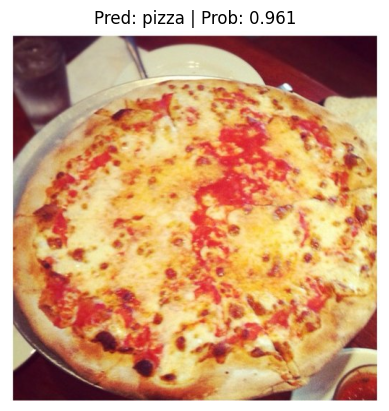

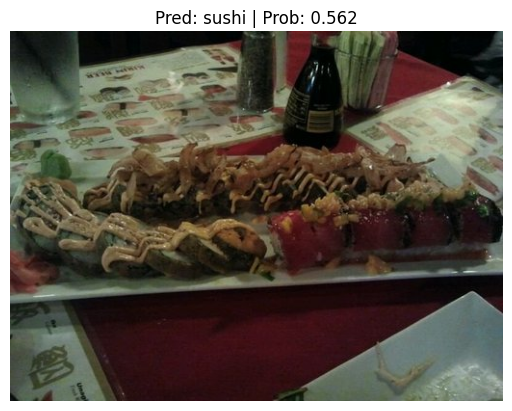

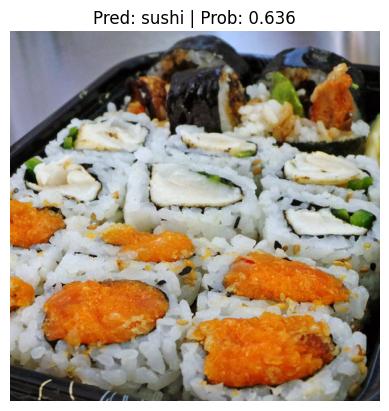

In [36]:
# make predictions

from pathlib import Path
import random

num_imgs = 3
test_img_path_list = list(Path(data_20_path /'test').glob("*/*.jpg"))
test_img_path_sample = random.sample(population= test_img_path_list,
                                     k= num_imgs)
    # randomly selects k number of images from population
for image_path in test_img_path_sample:
  pred_plot_img(model=model,
                image_path=image_path,
                class_names=class_names)

#### Predicting on custom image

In [37]:
# load the image

import requests
from pathlib import Path

#setup path
data_path = Path('data/')
custom_image_path = data_path/'pizza-image.jpeg'

# download if not already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/aashu-0/images/refs/heads/main/IMG_20230924_214608.jpg")
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists')

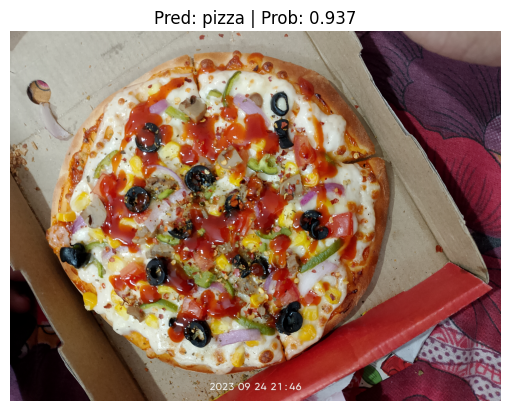

In [38]:
pred_plot_img(model=model,
              image_path=custom_image_path,
              class_names=class_names
              )